In [1]:
import torch, pickle, argparse, os
import importlib
from fig_settings import *
from util import *
from torch.utils.data import DataLoader, random_split, Subset, ConcatDataset

In [15]:
run_id = 'material_model_run_z15'
params = torch.load(run_id+'/args.pkl', weights_only=True)
args = argparse.Namespace(**params)  
folder = f'overleaf/figs/{run_id}' 
if not os.path.exists(folder):
    os.makedirs(folder)

In [16]:
mm = importlib.import_module(run_id + '.' + args.material_model)
from util import LossFunction
from m_encoder import *

device = torch.device(args.device if torch.cuda.is_available() else "cpu")

data_files = [file.strip() for file in args.data_path.split(",")]
print(data_files)

datasets = [
    ViscoelasticDataset(
        data_path=file,
        step=args.step,
        device=device,
        encoder=False,
    )
    for file in data_files
]
dataset = ConcatDataset(datasets)
length = len(dataset)

train_indices = args.train_indices
val_indices = args.val_indices
trainset = Subset(dataset, train_indices)
valset = Subset(dataset, val_indices)


loss_function = LossFunction()

ae_E = AutoEncoder(501, args.encoder_hidden_dim, args.encoder_latent_dim).to(
    device
)
ae_nu = AutoEncoder(501, args.encoder_hidden_dim, args.encoder_latent_dim).to(
    device
)

encoder_path = args.encoder_path

ae_E.load_state_dict(torch.load(f"{encoder_path}/ae_E.pth", weights_only=True, map_location=torch.device('cpu')))
ae_nu.load_state_dict(torch.load(f"{encoder_path}/ae_nu.pth", weights_only=True, map_location=torch.device('cpu')))

['data/2024-10-13_PC1D_process10_data.pkl', 'data/2024-10-13_PC1D_process11_data.pkl', 'data/2024-10-13_PC1D_process12_data.pkl', 'data/2024-10-13_PC1D_process13_data.pkl', 'data/2024-10-13_PC1D_process14_data.pkl', 'data/2024-10-13_PC1D_process15_data.pkl', 'data/2024-10-13_PC1D_process16_data.pkl', 'data/2024-10-13_PC1D_process17_data.pkl', 'data/2024-10-13_PC1D_process18_data.pkl', 'data/2024-10-13_PC1D_process19_data.pkl', 'data/2024-10-13_PC1D_process0_data.pkl']


<All keys matched successfully>

In [17]:
energy_input_dim = (1, args.niv, args.encoder_latent_dim * 2)
energy_hidden_dim = args.hidden_dim
dissipation_input_dim = (1, args.niv, args.encoder_latent_dim * 2)
dissipation_hidden_dim = args.hidden_dim
ae_E.freeze_encoder()

vmm = mm.ViscoelasticMaterialModel(
    energy_input_dim,
    energy_hidden_dim,
    dissipation_input_dim,
    dissipation_hidden_dim,
    ae_E.encoder,
    ae_nu.encoder,
    dt = args.step/5000.0
).to(device)

vmm.load_state_dict(torch.load(f"{run_id}/vmm.pth", weights_only=True, map_location=torch.device('cpu')))

<All keys matched successfully>

In [5]:
ae_E.freeze_encoder()
print(len([p for p in ae_E.parameters() if p.requires_grad]))

6


In [37]:
e_temp = torch.repeat_interleave(torch.tensor(0.4, requires_grad=True).reshape(1, 1), E.shape[0], 0).to(device)
xi = torch.ones_like(e_temp)
w = vmm.energy_function(e_temp, xi, E, nu)
s = torch.autograd.grad(w.sum(), e_temp, create_graph=True, retain_graph=True)[0]
E0 = torch.autograd.grad(s.sum(), e_temp)[0]

NameError: name 'E' is not defined

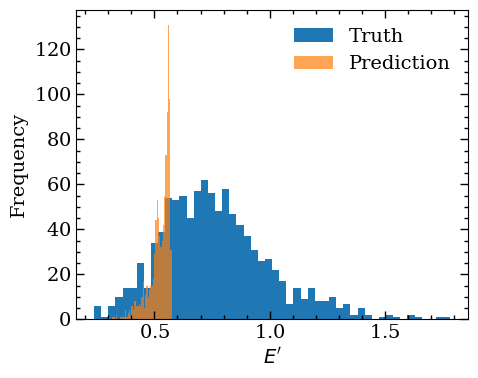

In [74]:
plt.figure(figsize=(5, 4))
plt.hist(data['E_prime'].flatten(), bins=50, label='Truth')
plt.hist(E0.detach().cpu().numpy(), bins=50, alpha=0.7, label='Prediction')
plt.ylabel('Frequency')
plt.xlabel(r'$E^\prime$')
plt.legend()
plt.tight_layout()
# plt.savefig(f'overleaf/figs/E_prime_distribution.pdf')
plt.show()

E reconstruction error: 0.21220768988132477
nu reconstruction error: 0.2154962718486786


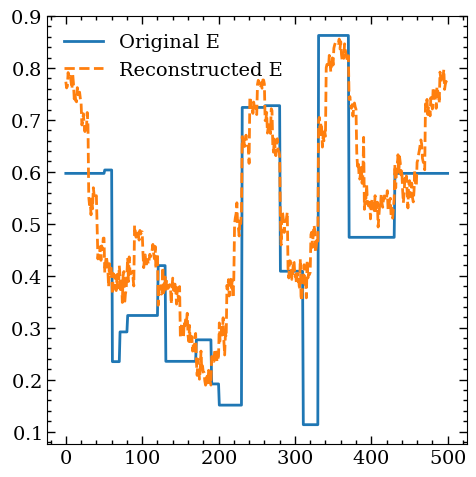

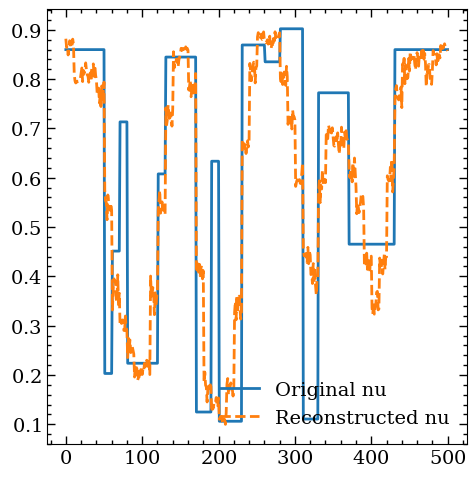

In [215]:
n = 8
E_recon = ae_E(E).detach().numpy()
nu_recon = ae_nu(nu).detach().numpy()
print("E reconstruction error:", loss_function.L2RelativeError(torch.tensor(E_recon).unsqueeze(-1), E.unsqueeze(-1)).item())
print("nu reconstruction error:", loss_function.L2RelativeError(torch.tensor(nu_recon).unsqueeze(-1), nu.unsqueeze(-1)).item())
plt.figure(figsize=(5,5))
plt.plot(E.detach().numpy()[n], label='Original E')
plt.plot(E_recon[n], '--', label='Reconstructed E')
plt.legend()
plt.tight_layout()
plt.savefig(f"{folder}/E_reconstruction.pdf")
plt.show()

plt.figure(figsize=(5,5))
plt.plot(nu.detach().numpy()[n], label='Original nu')
plt.plot(nu_recon[n], '--', label='Reconstructed nu')
plt.legend(loc='lower right')
plt.tight_layout()
# plt.savefig(f"{folder}/nu_reconstruction.pdf")
plt.show()


In [79]:
spred.shape, s.shape

(torch.Size([1000, 101, 1]), torch.Size([1000, 101, 1]))

In [208]:
spred, xipred = mm.prediction_step(vmm, e, e_dot, E, nu)
rel_error = loss_function.L2RelativeError(spred, s, reduction=None).detach().cpu().numpy()

In [209]:
rel_error[rel_error.argsort()[-3]]

0.17961605

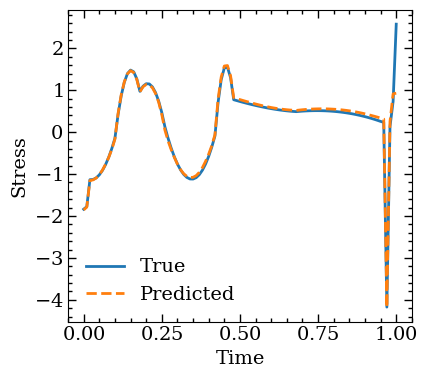

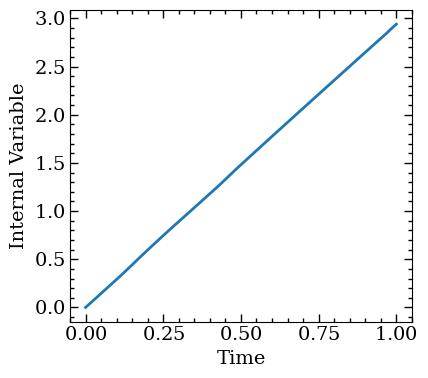

In [210]:
id = rel_error.argsort()[-2]
time = torch.linspace(0, 1, s.shape[1])
plt.figure(figsize=(4.5,4))
plt.plot(time, s[id, :, 0].cpu().detach().numpy(), label="True")
plt.plot(time, spred[id, :, 0].cpu().detach().numpy(), '--', label="Predicted")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Stress")
plt.tight_layout()
plt.savefig(f"{folder}/stress_prediction.pdf")
plt.show()

plt.figure(figsize=(4.5,4))
plt.plot(time, xipred[id, :, 0].cpu().detach().numpy(), label="True")
plt.xlabel("Time")
plt.ylabel("Internal Variable")
plt.tight_layout()
# plt.savefig(f"{folder}/internal_variable_prediction.pdf")
plt.show()

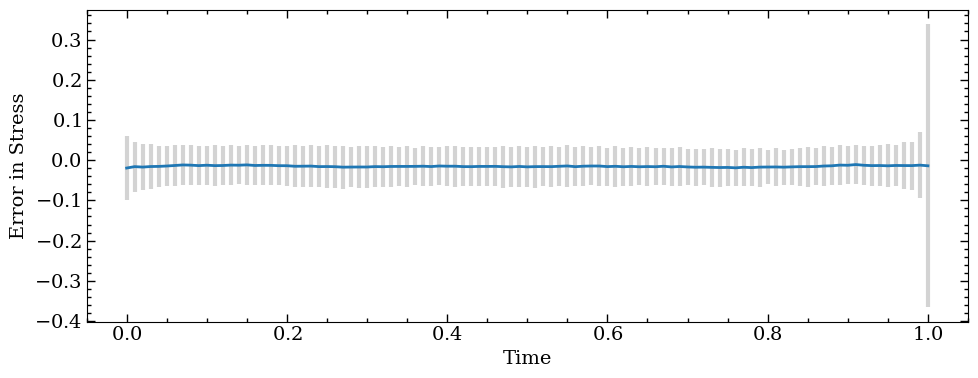

In [8]:
error = s - spred
mean = torch.mean(error, dim=0)
std = torch.std(error, dim=0)
plt.figure(figsize=(10,4))
plt.errorbar(time,
            mean[:, 0].cpu().detach().numpy(),
            yerr=std[:, 0].cpu().detach().numpy(),
            ecolor='lightgray',
            elinewidth=3,
            )
plt.xlabel("Time")
plt.ylabel("Error in Stress")
plt.tight_layout()
plt.savefig(f"{folder}/stress_prediction_error.pdf")
plt.show()

## Plot energy and dissipation contours

In [49]:
len(trainset[0][0])

4

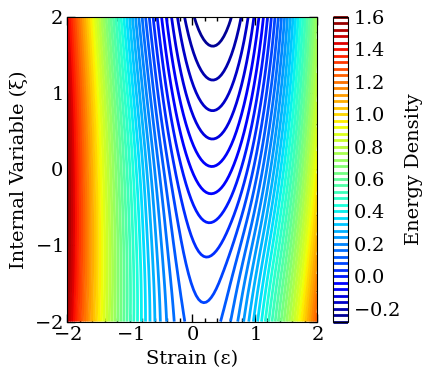

In [18]:
eps = torch.linspace(-2, 2, 100).reshape(-1, 1).to(device)
xi = torch.linspace(-2, 2 , 100).reshape(-1, 1).to(device)
EPS, XI = torch.meshgrid(eps.squeeze(), xi.squeeze(), indexing='ij')
E0 = trainset[0][0][2]
nu0 = trainset[0][0][3]
inputs = (
        EPS.reshape(-1, 1),
        XI.reshape(-1, 1),
        E0.repeat(EPS.numel(), 1),
        nu0.repeat(EPS.numel(), 1)
        )
m_features = vmm.microstructure_encoder(inputs[2], inputs[3])
inputs = (inputs[0], inputs[1], m_features)
Z = vmm.energy_function(*inputs).reshape(EPS.shape).detach().cpu().numpy()

plt.figure(figsize=(4.5,4))
plt.contour(EPS.cpu().numpy(), XI.cpu().numpy(), Z, levels=50, cmap='jet')
plt.colorbar(label='Energy Density')
plt.xlabel('Strain (ε)')
plt.ylabel('Internal Variable (ξ)')
plt.tight_layout()
plt.savefig(f"{folder}/energy_contour.pdf")
plt.show()

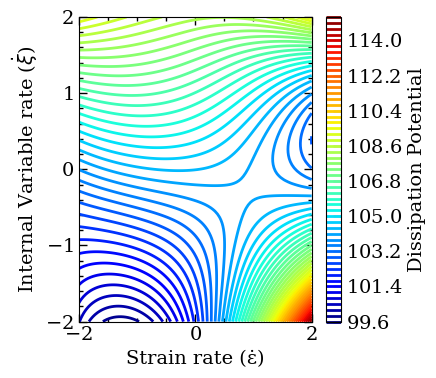

In [19]:
eps_dot = torch.linspace(-2, 2, 100).reshape(-1, 1).to(device)
xi_dot = torch.linspace(-2, 2 , 100).reshape(-1, 1).to(device)
EPS_dot, XI_dot = torch.meshgrid(eps_dot.squeeze(), xi_dot.squeeze(), indexing='ij')
E0 = trainset[0][0][2]
nu0 = trainset[0][0][3]
inputs = (
        EPS.reshape(-1, 1),
        XI.reshape(-1, 1),
        E0.repeat(EPS.numel(), 1),
        nu0.repeat(EPS.numel(), 1)
        )
m_features = vmm.microstructure_encoder(inputs[2], inputs[3])
inputs = (inputs[0], inputs[1], m_features)
Z = vmm.dissipation_potential(*inputs).reshape(EPS_dot.shape).detach().cpu().numpy()

plt.figure(figsize=(4.5,4))
plt.contour(EPS_dot.cpu().numpy(), XI_dot.cpu().numpy(), Z, levels=50, cmap='jet')
plt.colorbar(label='Dissipation Potential')
plt.xlabel('Strain rate (ε̇)')
plt.ylabel(r'Internal Variable rate ($\dot{\xi}$)')
plt.tight_layout()
plt.savefig(f"{folder}/dissipation_contour.pdf")
plt.show()

## Dissipation contours for fixed strain rate values

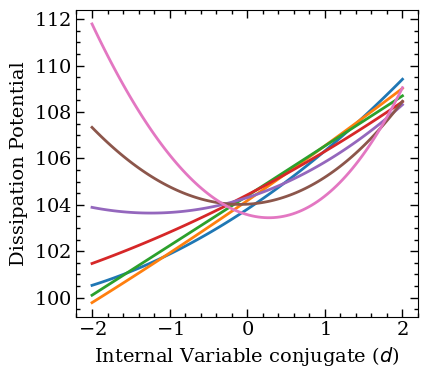

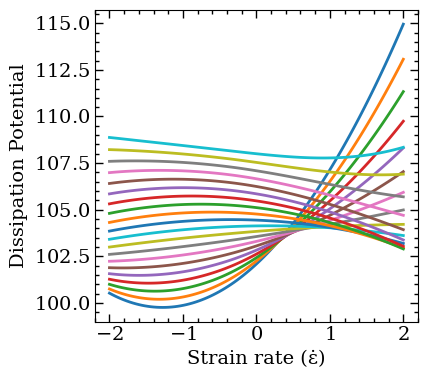

In [24]:
plt.figure(figsize=(4.5,4))
plt.plot(XI_dot[0, :].cpu().detach().numpy(),
        Z.T[:,::15], label='Predicted xi')
plt.xlabel(r'Internal Variable conjugate ($d$)')
plt.ylabel('Dissipation Potential')
plt.tight_layout()
plt.savefig(f"{folder}/dissipation_slices_xidot.pdf")
plt.show()

plt.figure(figsize=(4.5,4))
plt.plot(EPS[:, 0].cpu().detach().numpy(),
        Z[:,::5], label='Predicted xi')
plt.xlabel('Strain rate (ε̇)')
plt.ylabel('Dissipation Potential')
plt.tight_layout()
plt.savefig(f"{folder}/dissipation_slices_edot.pdf")
plt.show()

In [48]:
ae_E.freeze_encoder()
# vmm.E_encoder.freeze()
vmm.E_encoder = ae_E.encoder
[i.shape for i in list(vmm.parameters())]

[torch.Size([100, 32]),
 torch.Size([100]),
 torch.Size([1, 100]),
 torch.Size([1]),
 torch.Size([100, 32]),
 torch.Size([100]),
 torch.Size([1, 100]),
 torch.Size([1]),
 torch.Size([200, 501]),
 torch.Size([200]),
 torch.Size([200, 200]),
 torch.Size([200]),
 torch.Size([15, 200]),
 torch.Size([15]),
 torch.Size([200, 501]),
 torch.Size([200]),
 torch.Size([200, 200]),
 torch.Size([200]),
 torch.Size([15, 200]),
 torch.Size([15])]

In [13]:
steps = torch.arange(10, 150, 10, dtype=torch.int32).tolist()
rel_errors = {}
for step in steps:
    e = torch.tensor(data["strain"][:N, ::step], dtype=torch.float32).to(device)
    e_dot = torch.tensor(data["strain_rate"][:N, ::step], dtype=torch.float32).to(device)
    s = torch.tensor(data["stress"][:N, ::step], dtype=torch.float32).to(device)
    vmm.dt = step/5000
    spred, xipred = mm.prediction_step(vmm, e, e_dot, E, nu)
    rel_error = loss_function.L2RelativeError(spred, s).item()
    rel_errors[vmm.dt] = rel_error

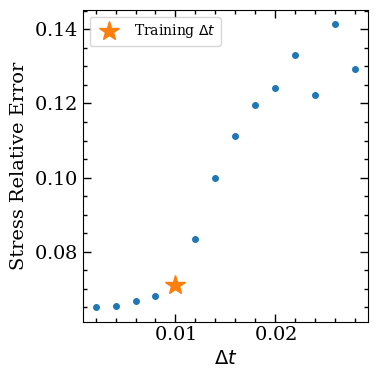

In [14]:
plt.figure(figsize=(4,4))
plt.plot(list(rel_errors.keys()), list(rel_errors.values()), 'o')
plt.plot([0.01], [rel_errors[0.01]], '*', markersize=15, label=r'Training $\Delta t$')
plt.legend(frameon=True, fontsize=10)
plt.xlabel(r'$\Delta t$')
plt.ylabel('Stress Relative Error')
plt.tight_layout()
plt.savefig(f"{folder}/time_step_sensitivity.pdf")
plt.show()

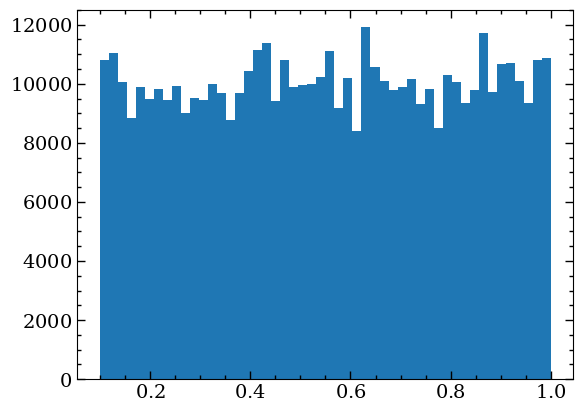

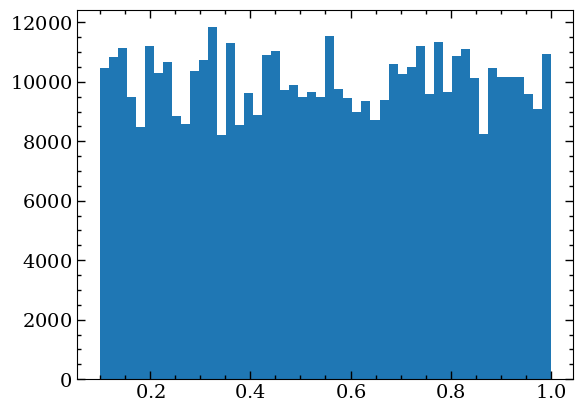

In [107]:
plt.hist(E.detach().cpu().numpy().flatten(), bins=50)

plt.show()
plt.hist(nu.detach().cpu().numpy().flatten(), bins=50)
plt.show()

In [25]:
train_dataloader = DataLoader(trainset, batch_size=args.batch_size, shuffle=False)
val_dataloader = DataLoader(valset, batch_size=args.batch_size, shuffle=False)

In [29]:
N = 99
# train_rel_error = [] 
# for train_batch_x, train_batch_y in train_dataloader:
#         train_rel_error.append(loss_function.L2RelativeError(
#             vmm(*train_batch_x)[0], train_batch_y, reduction=None
#         ))
train_rel_error = torch.cat(train_rel_error, dim=0).detach().cpu().numpy()

In [32]:
# val_rel_error = [] 
# for val_batch_x, val_batch_y in val_dataloader:
#         val_rel_error.append(loss_function.L2RelativeError(
#             vmm(*val_batch_x)[0], val_batch_y, reduction=None
#         ))
val_rel_error = torch.cat(val_rel_error, dim=0).detach().cpu().numpy()

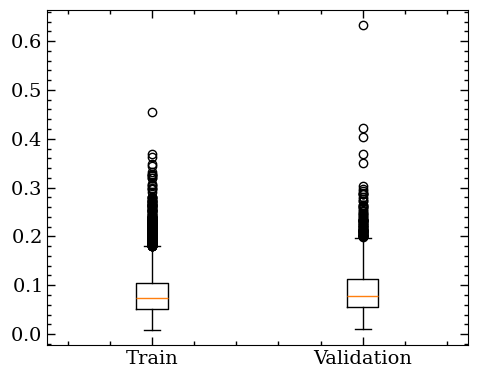

In [33]:
plt.figure(figsize=(5,4))
plt.boxplot([train_rel_error, val_rel_error], tick_labels=['Train', 'Validation'])
plt.tight_layout()
# plt.savefig(f"{folder}/train_val_error_boxplot.pdf")
plt.show()

In [35]:
import numpy as np

In [36]:
argsort = np.argsort(val_rel_error)
# worst_index = val_indices[argsort[-10:]]
median_index = val_indices[argsort[len(argsort)//2]]
best_index = val_indices[argsort[0]]


In [39]:
worst_index = [val_indices[argsort[i]] for i in range(1, 20) ]  # Just the single worst case for brevity

In [13]:
argsort = np.argsort(train_rel_error)
# median_index = train_indices[argsort[len(argsort)//2]]
# best_index = train_indices[argsort[0]]
worst_index = [train_indices[argsort[-i]] for i in range(1, 20) ]  # Just the single worst case for brevity


In [14]:
# worst_index = best_index
# worst_index = median_index

In [15]:
val_batch_x[2].shape

torch.Size([200, 501])

In [16]:
val_batch_y[0,-N:,0].shape
time = torch.linspace(0, 1, 501)

time[-N:].shape

torch.Size([99])

In [41]:
with open('data/2024-10-13_PC1D_process0_data.pkl', 'rb') as f:
    data = pickle.load(f)

In [44]:
data['kernel'].shape

(1000, 5001, 1, 1)

0.011607621796429157
0.0016615695785731077


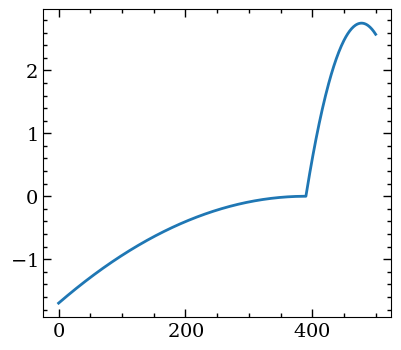

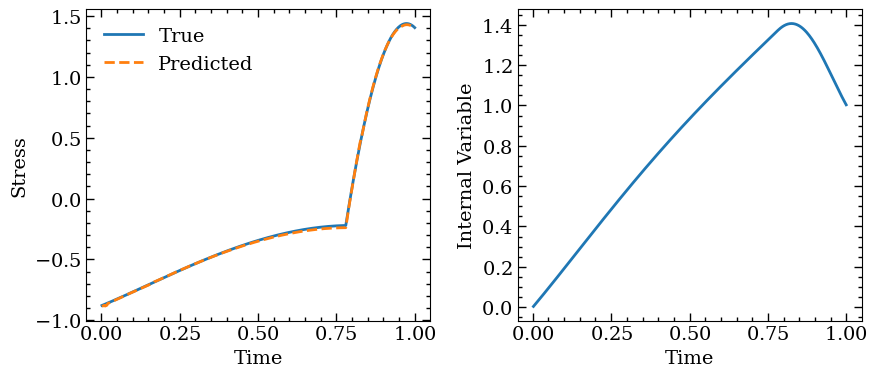

0.01256392803043127
0.011486440896987915


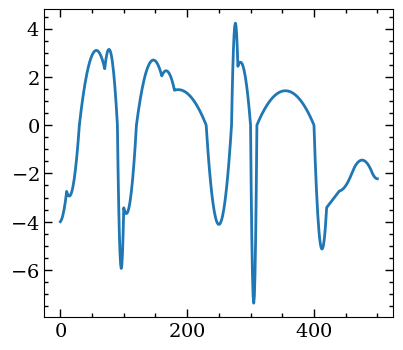

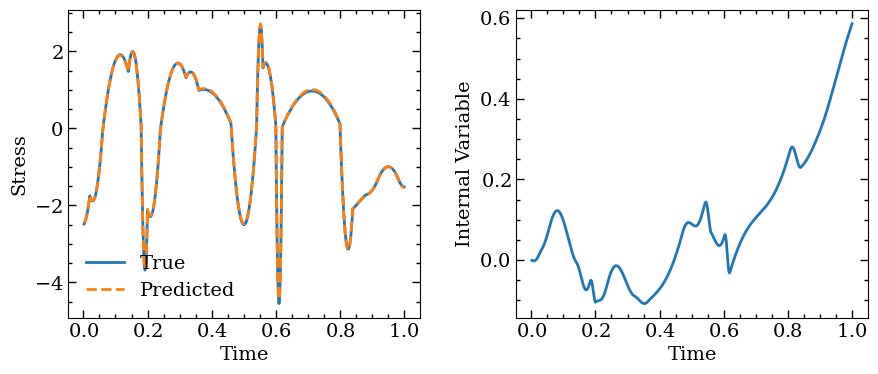

0.014227094128727913
0.00921640545129776


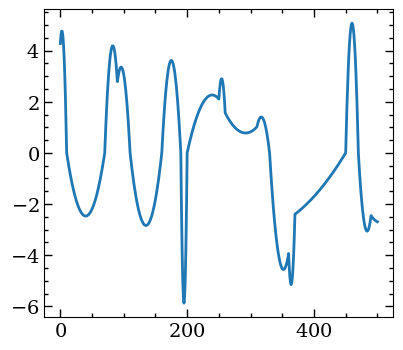

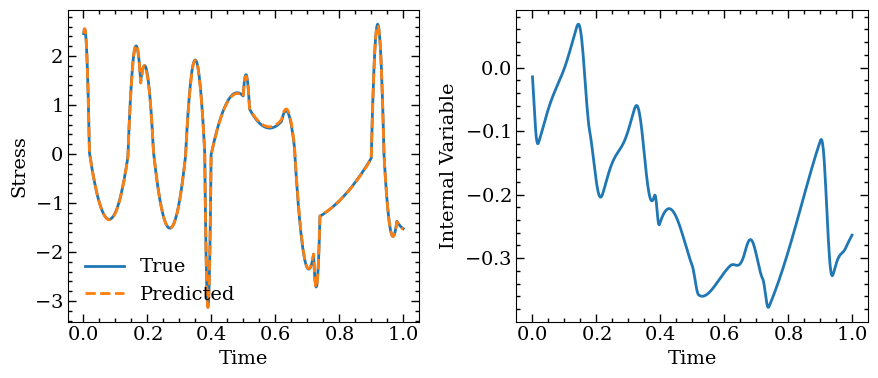

0.01653575524687767
0.017420250922441483


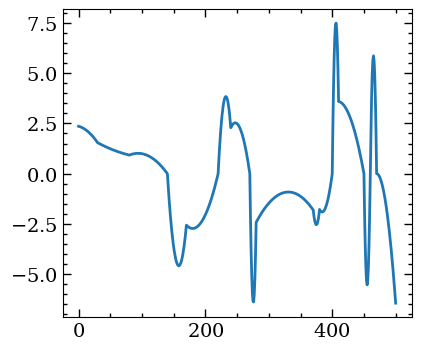

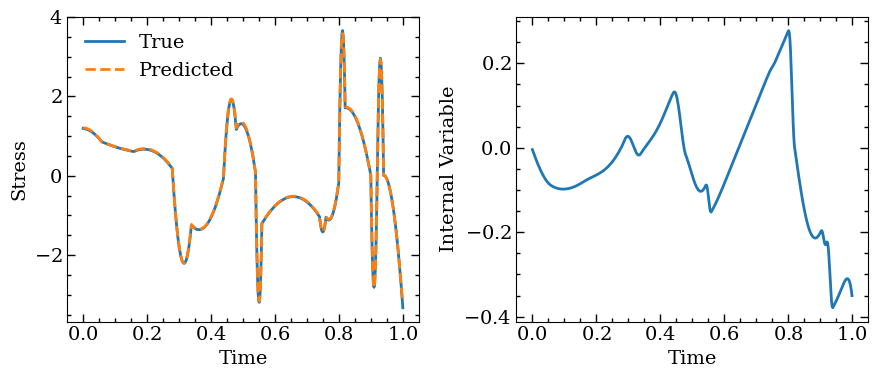

0.017528953030705452
0.009416698478162289


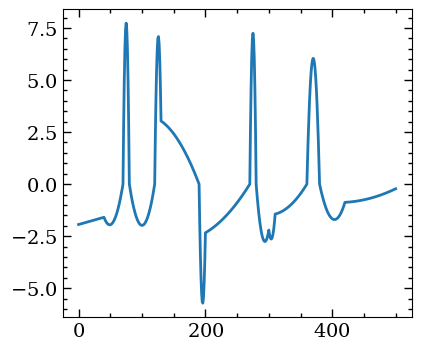

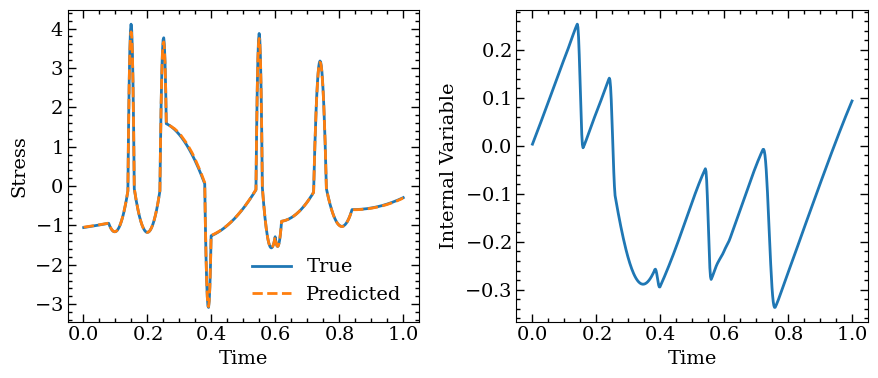

0.01880669966340065
0.015283388085663319


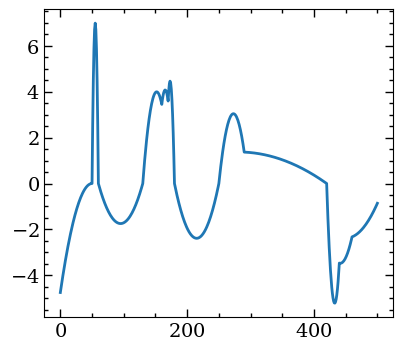

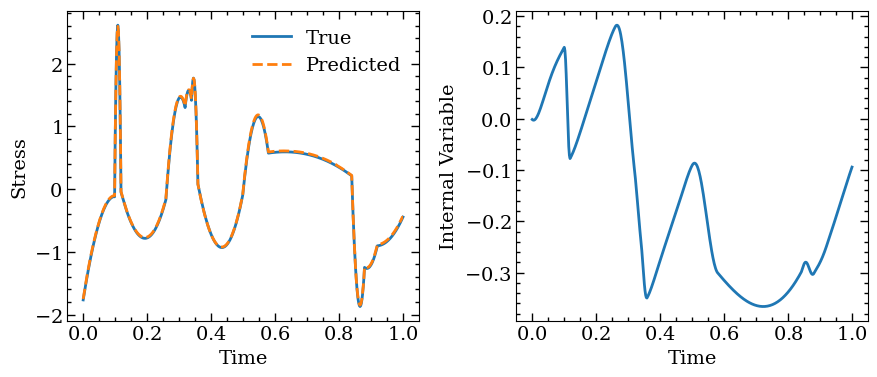

0.018832430243492126
0.011556627228856087


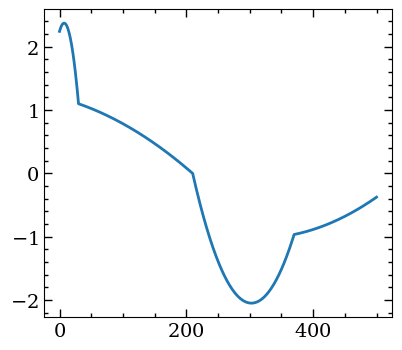

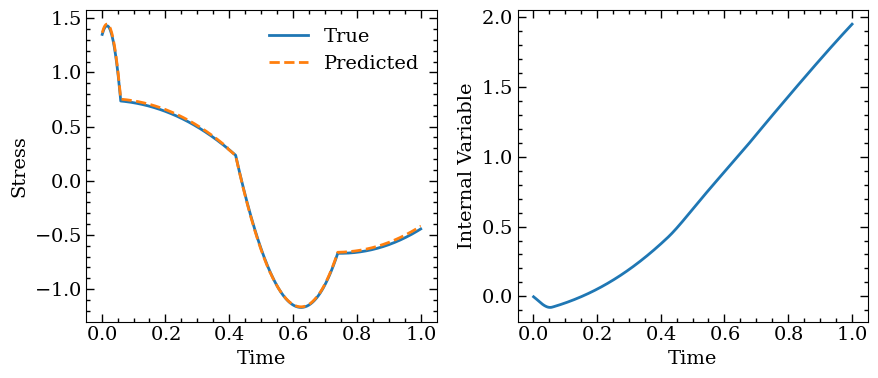

0.019296366721391678
0.015789251774549484


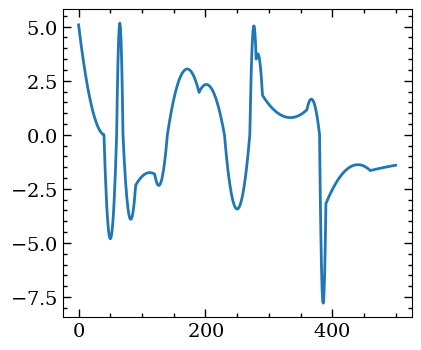

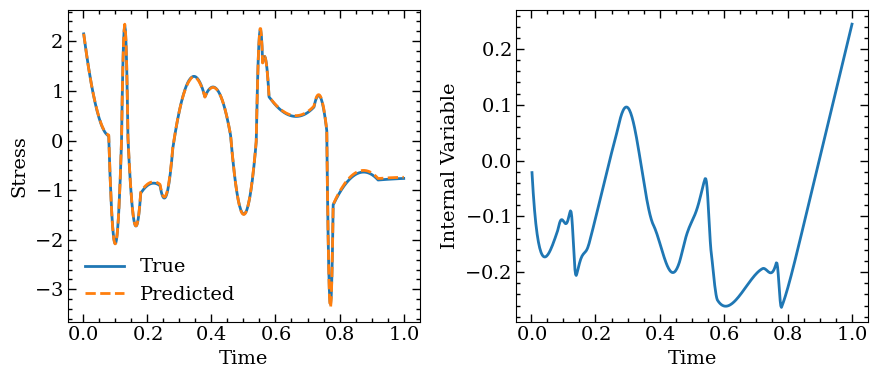

0.01947697252035141
0.005608602426946163


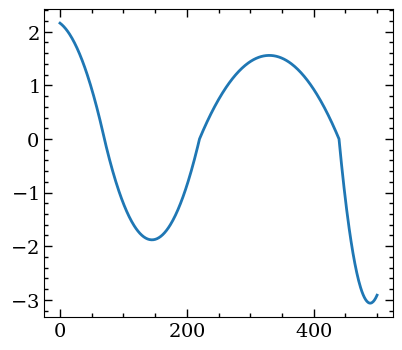

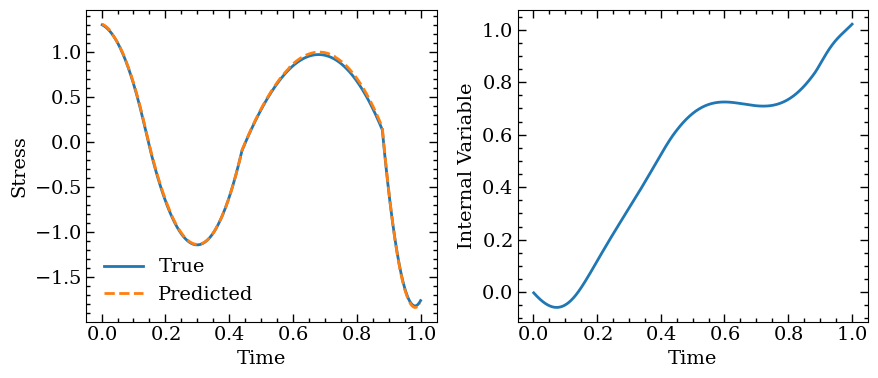

0.019564788788557053
0.01327340304851532


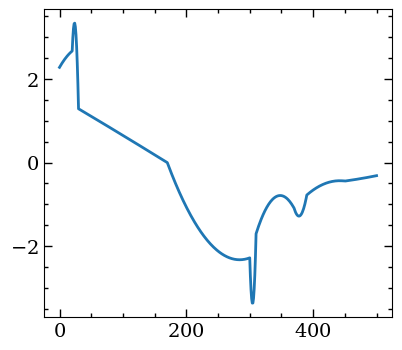

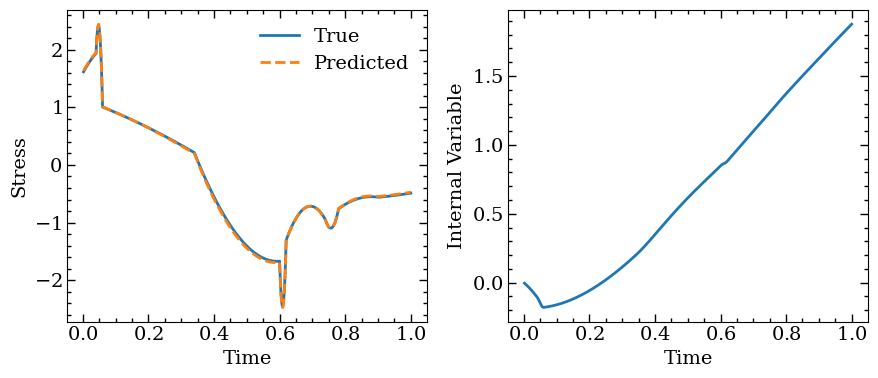

0.01961700990796089
0.01061980053782463


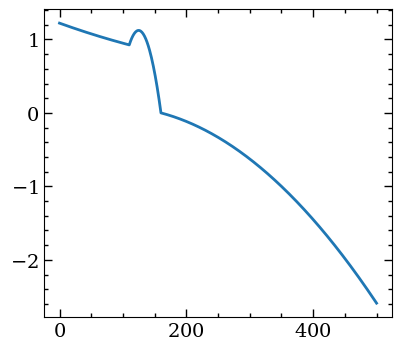

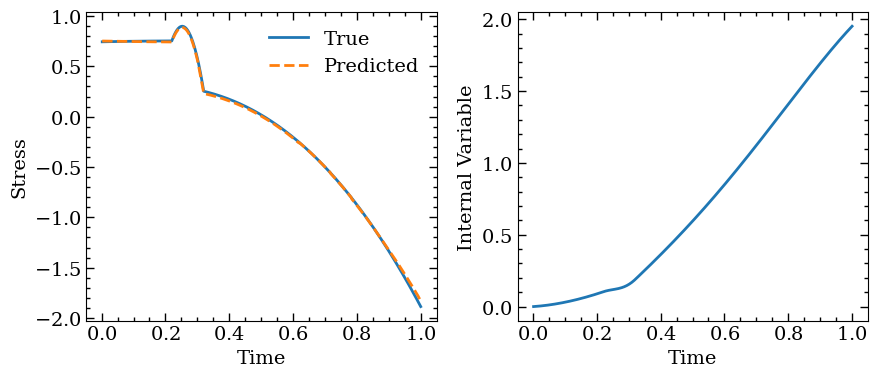

0.019933121278882027
0.025656849145889282


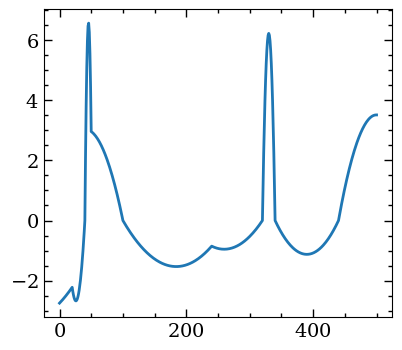

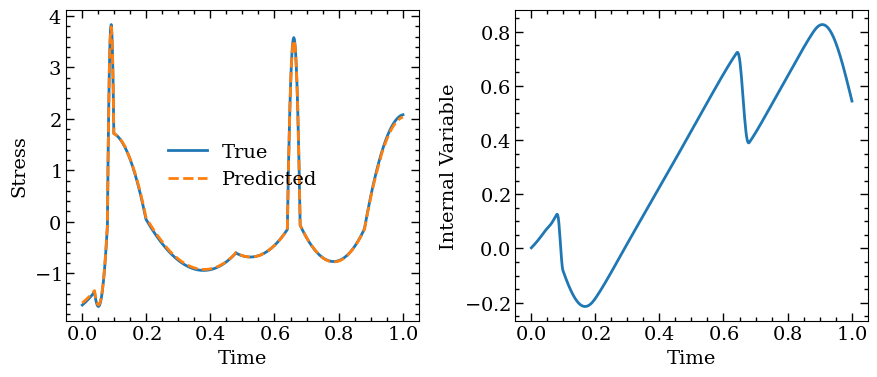

0.020840546116232872
0.008933153003454208


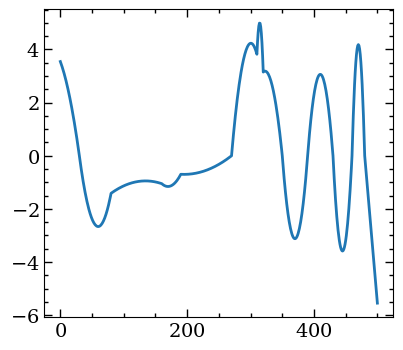

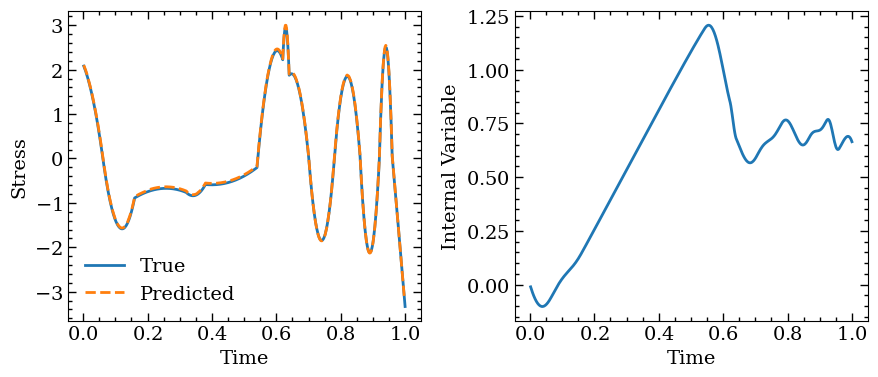

0.02088519185781479
0.0229593887925148


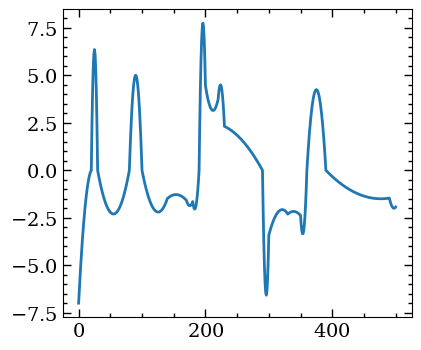

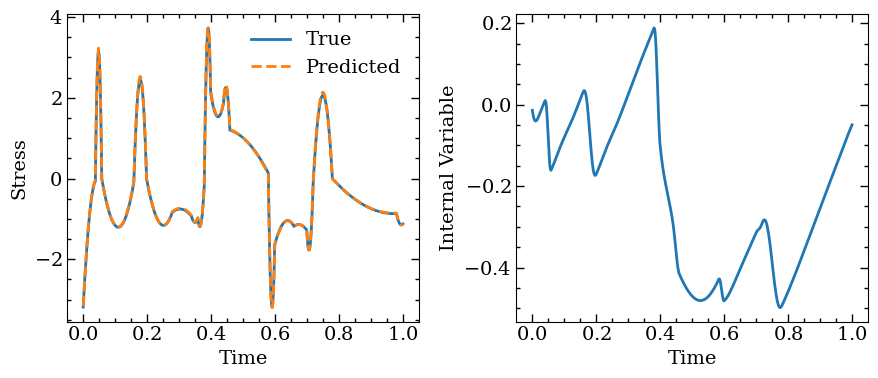

0.020960640162229538
0.022447090595960617


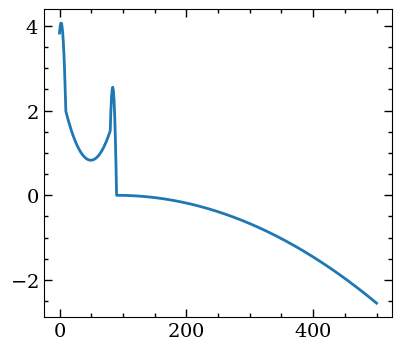

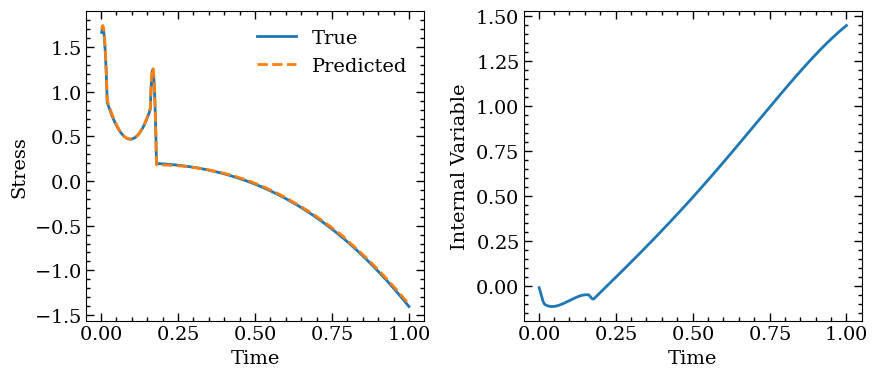

0.021182918921113014
0.014004816301167011


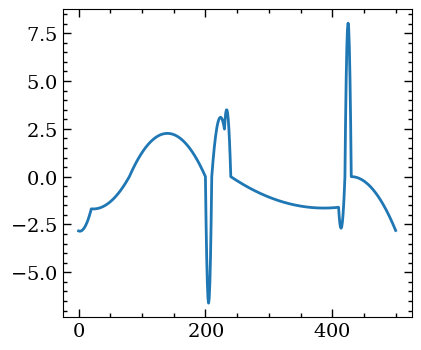

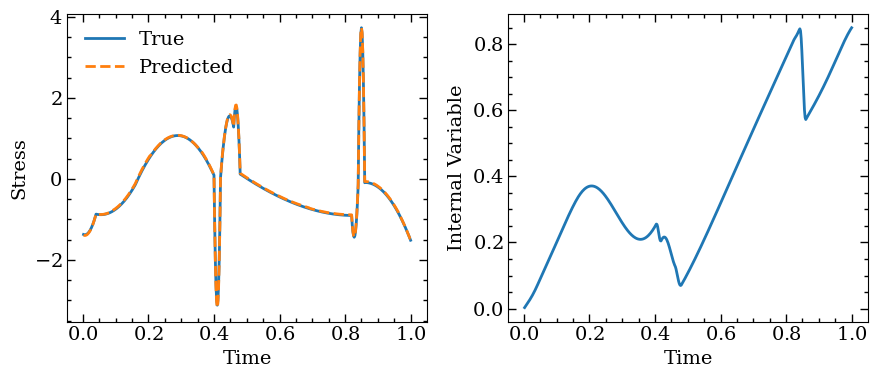

0.021311994642019272
0.0016607674770057201


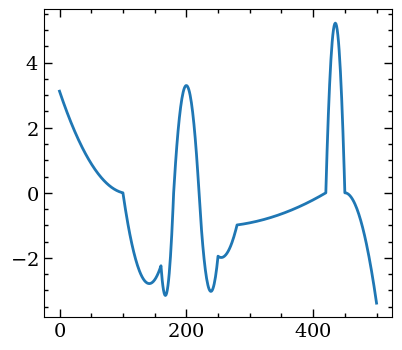

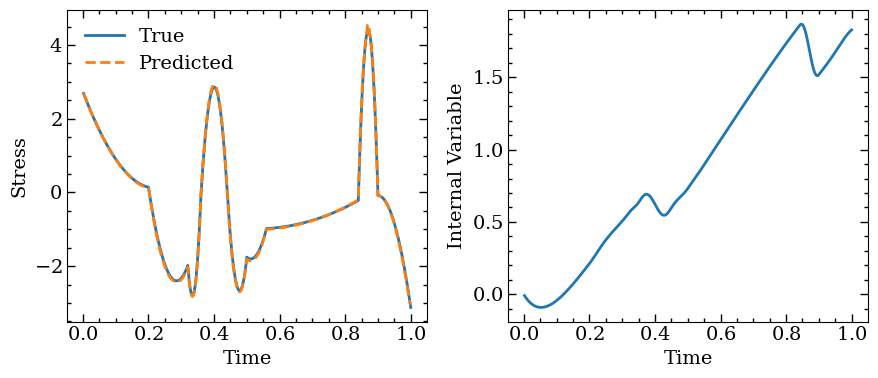

0.022303657606244087
0.02667398378252983


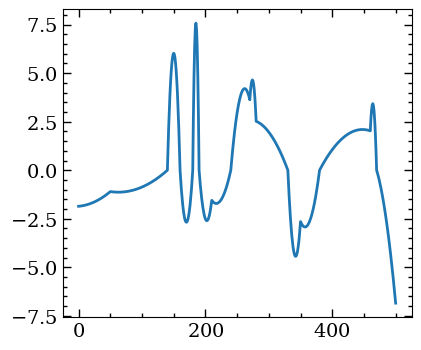

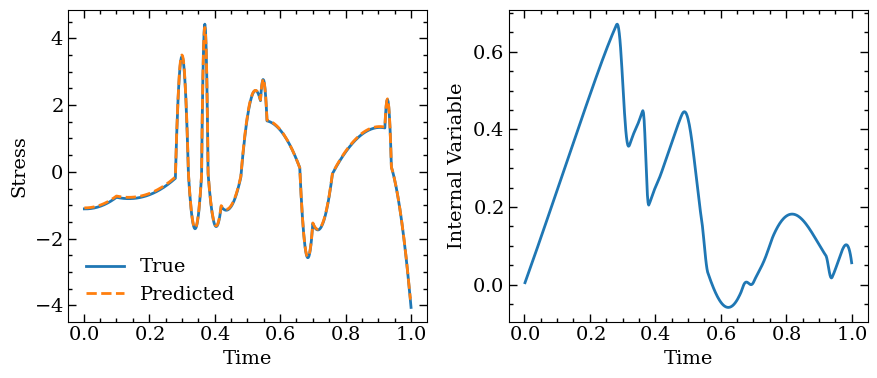

0.022402053698897362
0.034108005464076996


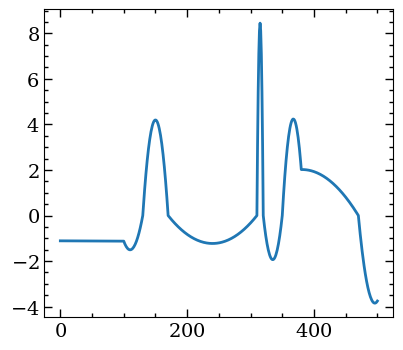

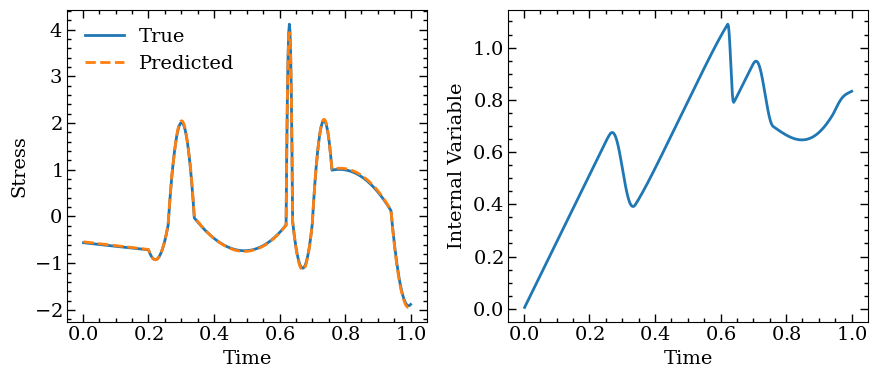

In [40]:
N = 500
time = torch.linspace(0, 1, 501)
for i in range(19):
    val_batch_x, val_batch_y = valset.dataset[worst_index[i]]
    val_batch_x = tuple([item.unsqueeze(0) for item in val_batch_x])
    val_batch_y = val_batch_y.unsqueeze(0)
    spred, xipred = mm.prediction_step(vmm, *val_batch_x)
    plt.plot(val_batch_x[1][0])
    print(loss_function.L2RelativeError(spred, val_batch_y).item())
    print(loss_function.L2RelativeError(spred[:,:-N], val_batch_y[:,:-N]).item())
    plt.figure(figsize=(9,4))
    plt.subplot(1,2,1)
    plt.plot(time[-N:], val_batch_y[0,-N:, 0].cpu().detach().numpy(), label="True")
    plt.plot(time[-N:], spred[0, -N:, 0].cpu().detach().numpy(), '--', label="Predicted")
    plt.xlabel("Time")
    plt.ylabel("Stress")
    # plt.suptitle("best case in Validation Set")
    plt.legend()

    plt.subplot(1,2,2)
    # plt.plot(time[-N:], seq[-N:], label="Equilibrium")
    # plt.plot(time, sneq, label="Non-Equilibrium")
    plt.plot(time[-N:], xipred[0,-N:,0].cpu().detach().numpy(), label="True")
    plt.tight_layout()
    plt.xlabel("Time")
    plt.ylabel("Internal Variable")
    plt.tight_layout()
    # plt.savefig(f"{folder}/worst_case_validation_stress.pdf")
    plt.show()


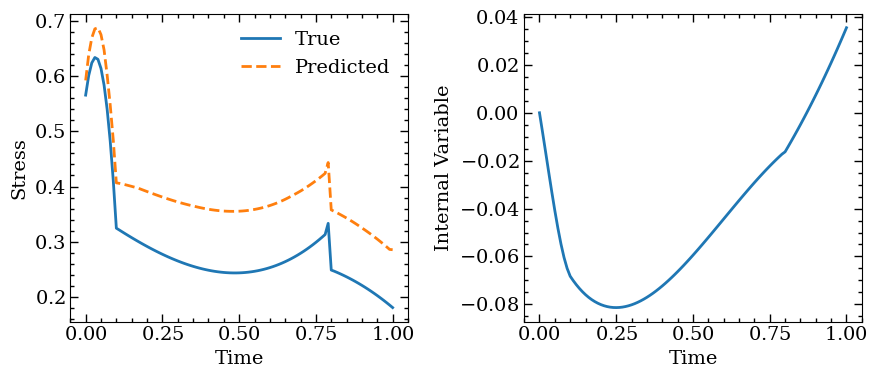

In [99]:
time = torch.linspace(0, 1, 101)
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.plot(time, val_batch_y[0, :, 0].cpu().detach().numpy(), label="True")
plt.plot(time, spred[0, :, 0].cpu().detach().numpy(), '--', label="Predicted")
plt.xlabel("Time")
plt.ylabel("Stress")
# plt.suptitle("best case in Validation Set")
plt.legend()
plt.subplot(1,2,2)
plt.plot(time, xipred[0,:,0].cpu().detach().numpy(), label="True")
plt.tight_layout()
plt.xlabel("Time")
plt.ylabel("Internal Variable")
plt.tight_layout()
# plt.savefig(f"{folder}/worst_case_validation_stress.pdf")
plt.show()


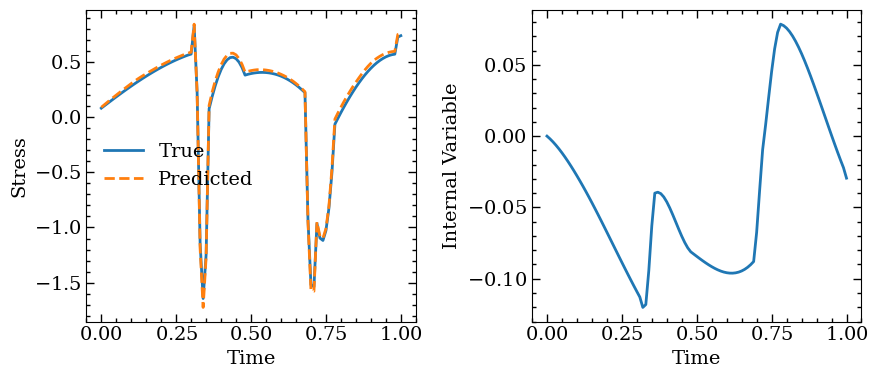

In [92]:
time = torch.linspace(0, 1, 101)
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.plot(time, val_batch_y[0, :, 0].cpu().detach().numpy(), label="True")
plt.plot(time, spred[0, :, 0].cpu().detach().numpy(), '--', label="Predicted")
plt.xlabel("Time")
plt.ylabel("Stress")
# plt.suptitle("best case in Validation Set")
plt.legend()
plt.subplot(1,2,2)
plt.plot(time, xipred[0,:,0].cpu().detach().numpy(), label="True")
plt.tight_layout()
plt.xlabel("Time")
plt.ylabel("Internal Variable")
plt.tight_layout()
plt.savefig(f"{folder}/median_case_validation_stress.pdf")
plt.show()


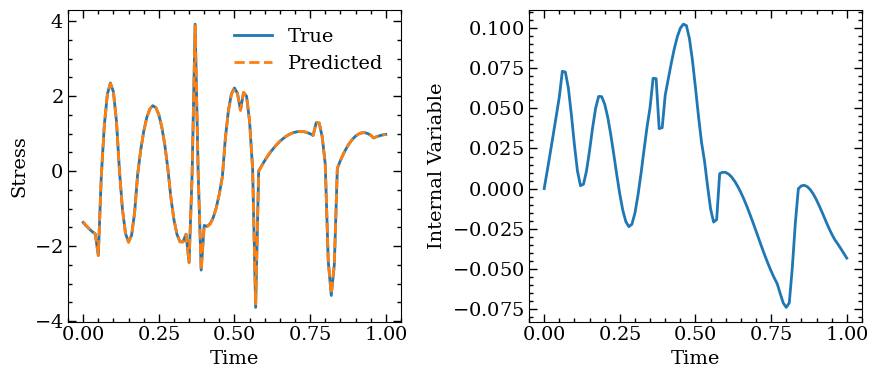

In [96]:
time = torch.linspace(0, 1, 101)
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.plot(time, val_batch_y[0, :, 0].cpu().detach().numpy(), label="True")
plt.plot(time, spred[0, :, 0].cpu().detach().numpy(), '--', label="Predicted")
plt.xlabel("Time")
plt.ylabel("Stress")
# plt.suptitle("best case in Validation Set")
plt.legend()
plt.subplot(1,2,2)
plt.plot(time, xipred[0,:,0].cpu().detach().numpy(), label="True")
plt.tight_layout()
plt.xlabel("Time")
plt.ylabel("Internal Variable")
plt.tight_layout()
plt.savefig(f"{folder}/best_case_validation_stress.pdf")
plt.show()


In [21]:
data_path1 = 'data/2024-10-13_PC1D_process10_data.pkl'
with open(data_path1, "rb") as f:
            data1 = pickle.load(f)

In [22]:
data1.keys()

dict_keys(['process_id', 'seed', 'n_samples', 'n_pieces_max', 'n_pieces_min', 'E_max', 'E_min', 'nu_max', 'nu_min', 'trajectory_interval', 'trajectory_bound', 'output_path', 'file_name', 'solve_for_viscous_stress', 'verbose', 'nt', 'T', 'maximum_iterations', 'relative_tolerance', 'n_cells', 'dim', 'FE_order', 'direct_solver', 'strain', 'strain_rate', 'stress', 'nu', 'E', 'nu_prime', 'E_prime', 'kernel', 'time', 'trajectory_generator_time', 'trajectory_generator_strain', 'pieces_points', 'E_pieces_values', 'nu_pieces_values'])

In [23]:
data_path2 = 'data/2024-12-10_mixture_random_field_process1_data.pkl'
with open(data_path2, "rb") as f:
            data2 = pickle.load(f)

In [24]:
data1.keys(), data2.keys()

(dict_keys(['process_id', 'seed', 'n_samples', 'n_pieces_max', 'n_pieces_min', 'E_max', 'E_min', 'nu_max', 'nu_min', 'trajectory_interval', 'trajectory_bound', 'output_path', 'file_name', 'solve_for_viscous_stress', 'verbose', 'nt', 'T', 'maximum_iterations', 'relative_tolerance', 'n_cells', 'dim', 'FE_order', 'direct_solver', 'strain', 'strain_rate', 'stress', 'nu', 'E', 'nu_prime', 'E_prime', 'kernel', 'time', 'trajectory_generator_time', 'trajectory_generator_strain', 'pieces_points', 'E_pieces_values', 'nu_pieces_values']),
 dict_keys(['process_id', 'n_samples', 'n_pieces_max', 'n_pieces_min', 'rho_max', 'rho_min', 'sigma_max', 'sigma_min', 'E_max', 'E_min', 'nu_max', 'nu_min', 'trajectory_interval', 'trajectory_bound', 'output_path', 'file_name', 'solve_for_viscous_stress', 'verbose', 'nt', 'T', 'maximum_iterations', 'relative_tolerance', 'n_cells', 'dim', 'FE_order', 'direct_solver', 'strain', 'strain_rate', 'stress', 'E', 'nu', 'nu_prime', 'E_prime', 'kernel', 'time', 'trajector

In [31]:
field = 'nu'
data1[field].shape, data2[field].shape,

((1000, 501), (1000, 501))